**Imports**

In [2]:
import httpx
import asyncio
import pandas as pd
import plotly.express as px

from os import path
from toolkit.models import Ticker, Timeframe
from toolkit.exchanges import Binance

**Utilities**

In [3]:
def highest_volume(tickers: list[Ticker]) -> list[Ticker]:
    """Sorts tickers based on volume and removes tickers with no volume."""
    filtered = filter(lambda x: x.price > 0 and x.volume > 0, tickers)
    tickers = sorted(filtered, key=lambda x: x.price * x.volume, reverse=True)
    return tickers

def filter_symbols(market: str, tickers: list[Ticker], blacklist: list[str] = []) -> list[Ticker]:
    """Returns list of tickers denominated in the provided market, excluding symbols that are blacklisted."""
    filtered = filter(lambda x: x.symbol.endswith(market) and not blacklisted(x.symbol, blacklist), tickers)
    return list(filtered)

def blacklisted(symbol: str, blacklist: list[str]) -> bool:
    """Checks if a blacklisted symbol is part of a given market and returns True if it is."""
    if len(blacklist) > 0:
        for item in blacklist:
            if symbol.startswith(item) or symbol.endswith(item):
                return True
    return False

def crop(lower: float, upper: float, df: pd.DataFrame) -> pd.DataFrame:
    diff = (df < upper) & (df > lower)
    return df.drop(columns=df.columns[diff.all()])

def relative(symbol: str, df: pd.DataFrame, bm: pd.DataFrame) -> pd.DataFrame:
    rel = df.reindex(bm.index, method="bfill")
    rel[symbol] = rel["close"].div(bm["close"] * rel["close"].iloc[0]) * bm["close"].iloc[0]
    return rel

def calc_relative(symbol: str, data: dict[str, pd.DataFrame]) -> pd.DataFrame:
    bm = data[symbol]
    rel = pd.DataFrame(index = bm.index)
    buffer = []
    for symbol, kline in data.items():
        try:
            df = relative(symbol, kline, bm)
            buffer.append(df[symbol])
        except TypeError:
            print(f"Error while processing {symbol}")
    rel = pd.concat(buffer, axis=1)
    return rel

**Load Data**

In [4]:
binance = Binance()
tickers = binance.tickers()

blacklist = ["UPUSDT", "DOWNUSDT", "BEARUSDT", "BULLUSDT"]
currencies = ["EUR", "JPY", "GBP", "CAD", "CNY", "CHF", "AUD"]
stablecoins = ["TUSD", "BUSD", "USDC", "PAX", "USDP", "DAI", "GUSD", "USDD", "USTC", "UST", "USDS", "FDUSD"]

usdt_markets = filter_symbols("USDT", tickers, blacklist + currencies + stablecoins)
usdt_volume = highest_volume(usdt_markets)

btc_markets = filter_symbols("BTC", tickers)
btc_volume = highest_volume(btc_markets)

usdt_dl = usdt_volume[:100]

print(f"Downloading {len(usdt_dl)} markets...")
usdt_data = []
async with httpx.AsyncClient() as client:
    usdt_symbols = [ticker.symbol for ticker in usdt_dl]
    for symbol in usdt_symbols:
        usdt_data.append(binance.kline(client, symbol, Timeframe.MINUTLY, 1000))
    usdt_data = await asyncio.gather(*usdt_data)
    usdt_data = dict(zip(usdt_symbols, usdt_data))
print("Finished downloading.")

Finished downloading.


**Sessions**

In [5]:
usdt_df = {k: pd.DataFrame.from_dict(v).set_index("time") for k, v in usdt_data.items()}

apac_session = {k: v.between_time("00:00", "06:00") for k, v in usdt_df.items()}
us_session = {k: v.between_time("13:30", "17:00") for k, v in usdt_df.items()}
eu_session = {k: v.between_time("07:00", "15:30") for k, v in usdt_df.items()}

**Calculate Relative Performance**

In [6]:
rel_apac = calc_relative("BTCUSDT", apac_session)
rel_apac = crop(0.95, 1.05, rel_apac)
rel_eu = calc_relative("BTCUSDT", eu_session)
rel_eu = crop(0.95, 1.05, rel_eu)

**Plotting**

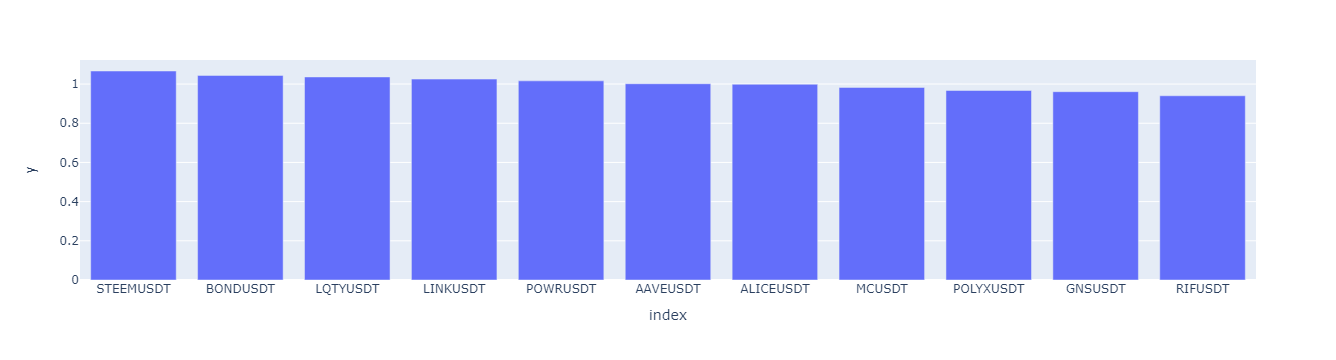

In [7]:
median = rel_apac.median().sort_values(ascending=False)

fig = px.bar(median, x = median.index, y = median)
fig.show()

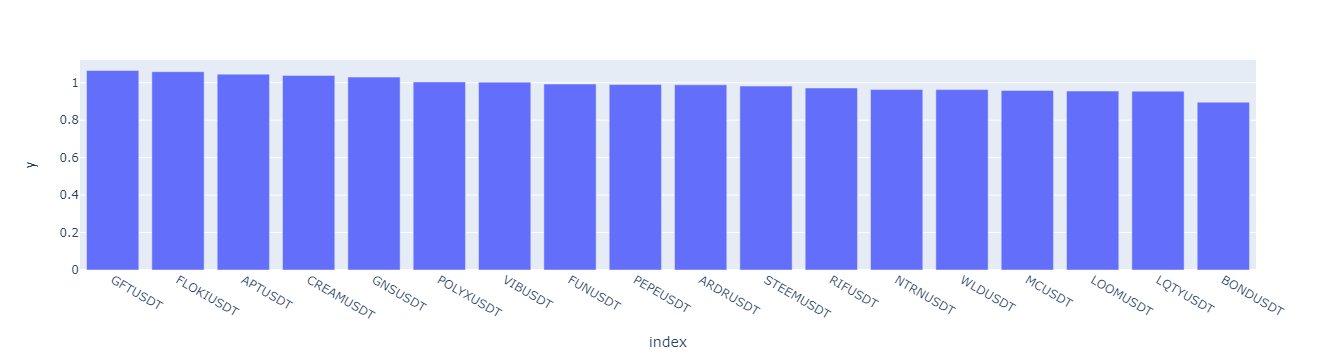

In [8]:
median = rel_eu.median().sort_values(ascending=False)

fig = px.bar(median, x = median.index, y = median)
fig.show()